# Bitcoin Trading with Machine Learning

This notebook experiments with machine learning algorithms to develop trading strategies for Bitcoin against  the dollar. The methodology can be summarised as follows:
* Train a regression model to predict the return of buying and holding bitcoin for the next hour based on hourly trading data available from the Coingecko API.
* Implement a trade execution strategy based on the predicted return.
* Backtest the strategy over various historical time windows to observe performance in different market conditions.

A dictionary of model types is provided by the parameter ```MODEL_DICT```. The Tensorflow based neural network had to be wrapped in a custom class so that it could be used in the same manner as the others, which use the Sci-Kit Learn API. 

In [1]:
import os
import json
import requests
import numpy as np
import pandas as pd
from typing import Iterable
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

import tensorflow as tf
import tensorflow.keras.layers as L

SEED = 123
np.random.seed(SEED)
N_WINDOWS = 5
FEATURES = ['10hour_premium','30hour_premium','60hour_premium','PreviousReturn']

class TfKerasModel:
    def __init__(self, input_dim):
        self.model = self.build_tf_keras_model(input_dim)

    def build_tf_keras_model(self, input_dim):
        inputs = L.Input(shape=(input_dim,))
        reshaped = L.Reshape((1,input_dim))(inputs)
        reshaped = L.BatchNormalization()(reshaped)
        conv1d = L.Conv1D(200,1)(reshaped)
        conv1d = L.Conv1D(200,1,activation='relu')(conv1d)
        flat = L.Flatten()(conv1d)
        dense = L.Dense(800,activation='relu')(flat)
        dense = L.Dense(400,activation='relu')(dense)
        dense = L.Dense(200,activation='relu')(dense)
        outputs = L.Dense(1, activation=tf.keras.activations.swish)(dense)
        
        model = tf.keras.Model(inputs, outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')
        print(model.summary())

        return model
    
    def fit(self, x, y):
        self.model.fit(x,
                       y,
                       epochs=100,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, monitor='loss'),
                                  tf.keras.callbacks.ReduceLROnPlateau(patience=10, monitor='loss')])
    
    def predict(self, x):
        raw_predictions = self.model.predict(x)
        predictions = np.clip(raw_predictions, 0, float('inf'))
        return predictions.flatten()

MODEL_DICT = {
    'lr': LinearRegression(n_jobs=8, normalize=True),
    'rfr': RandomForestRegressor(n_estimators=1000, n_jobs=8, random_state=SEED),
    'xgbr': XGBRegressor(),
    'gbr': GradientBoostingRegressor(n_estimators=1000, max_depth=2, random_state=SEED),
    'conv_r': TfKerasModel
}

MODEL = 'rfr'

/home/user/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Dataset Loading and Preprocessing

The Coingeck API only provides price, volume and market cap data, so the ```load_dataset``` function augments the data by adding rolling price averages.

In [2]:
def add_rolling_averages(df, windows=[10, 30, 60], unit='hour'):
    for window in windows:
        df[f'{window}_{unit}_price_avg'] = df['prices'].rolling(window).mean()
    df = df.dropna()
    return df

def format_date(ms):
    dt = datetime.fromtimestamp(ms/1000)
    date = dt.date().isoformat()
    return date

def build_historical_dataframe(data_dict, time_unit='hour'):
    new_dict = dict()
    dates = [data[0] for data in data_dict['prices']]
    for key in data_dict:
        new_dict[key] = [data[1] for data in data_dict[key]]
    new_dict['Date'] = list(map(format_date, dates))
    dataframe = pd.DataFrame(new_dict)
    dataframe = add_rolling_averages(dataframe, unit=time_unit)
    dataframe = dataframe.drop(index=dataframe.index[-1])
    return dataframe

def load_dataset(start_date, n_days=90):
    file_name = f'{start_date}_{n_days}days.csv'
    if not os.path.exists(file_name):
        start = datetime.fromisoformat(start_date)
        end = start + timedelta(days=n_days)
        url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range'
        parameters = {
            'id':'bitcoin',
            'vs_currency':'usd',
            'from':start.timestamp(),
            'to':end.timestamp()
        }
        response = requests.get(url, params=parameters).text
        data = json.loads(response)
        df = build_historical_dataframe(data, time_unit='hour')
        df.to_csv(file_name, index=False)
    df = pd.read_csv(file_name)
    return df

Time windows from which to sample data are selected at 90 day intervals from the current date. The number of windows is defined by ```N_WINDOWS```. The evenly indexed dataframes in the list ```datasets``` are used for training, with the others reserved for backtesting only.

In [3]:
start_dates = [datetime.now().date() - timedelta(days=90)]
for idx in range(1, N_WINDOWS):
    new_start_date = start_dates[-1] - timedelta(days=90)
    start_dates.append(new_start_date)
datasets = [load_dataset(s.isoformat()) for s in start_dates]
training_dataset = datasets[::2]

## Feature Selection and Model Training

Four features are engineered for the purposes of model training:
* The return over the previous hour ```PreviousReturn```.
* The ratio of the current price to the 10 hour moving average ```10hour_premium```.
* The ratio of the current price to the 30 hour moving average ```30hour_premium```.
* The ratio of the current price to the 60 hour moving average ```60hour_premium```.

The model is then trained and it performance visualised by plotting the distribution of it prediction errors.

In [4]:
def get_features_and_labels(df):
    df = df.drop(columns='Date').drop(index=df.index[-1])
    df['PreviousReturn'] = df['prices'] / df['prices'].shift(1)
    df.dropna(inplace=True)
    df['FutureReturn'] = df['prices'].shift(-1) / df['prices']
    df.dropna(inplace=True)
    df['10hour_premium'] = df['prices'] / df['10_hour_price_avg']
    df['30hour_premium'] = df['prices'] / df['30_hour_price_avg']
    df['60hour_premium'] = df['prices'] / df['60_hour_price_avg']
    features = df[FEATURES]

    y = df['FutureReturn']
    
    return (features, y)


def plot_feature_importances(model, features):
    importances = model.feature_importances_
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(features.columns, importances)
    plt.tight_layout()

    
def plot_distributions(data, mu, sigma, name):
    pecentiles = np.quantile(data, np.arange(0, 1.001, .001))
    density_fn = norm.pdf(pecentiles, mu, sigma)

    plt.figure()
    plt.scatter(data, np.zeros_like(data))
    plt.plot(pecentiles, density_fn, c='red')
    plt.text(x=pecentiles[900], 
             y=density_fn[900],
             s=f'Mean {name} : {round(mu, 5)}\nStd {name}: {round(sigma, 5)}')
    

def train_model(data, model, visualise_performance=False):
    if isinstance(data, list):
        features = []
        y = []
        for df in data:
            f, y_ = get_features_and_labels(df)
            features.append(f)
            y.append(y_)
        features = pd.concat(features)
        y = pd.concat(y)
    else:
        features, y = get_features_and_labels(data)

    x_train, x_test, y_train, y_test = train_test_split(features, y, random_state=SEED)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Calculate error statistics
    errors = np.abs(y_test - y_pred)
    errors = np.sort(errors)
    mean_error = errors.mean()
    std_error = errors.std()
    
    # Calculate true hourly return statistics
    y_test = np.sort(y_test)
    mean_ret = y_test.mean()
    std_ret = y_test.std()

    if visualise_performance:
        # Visualise hourly return distribution
        plot_distributions(y_test, mean_ret, std_ret, 'Return')
                
        # Visualise absolute error distribution
        plot_distributions(errors, mean_error, std_error, 'Error')

        if hasattr(model, 'feature_importances_'):
            plot_feature_importances(model, features)

        plt.show()
    
    return features, y, model, mean_error, std_error

In [5]:
if MODEL == 'conv_r':
    # If we're using the tf based convolutional model, we need to specify the input size based on the number of features
    model = MODEL_DICT[MODEL](len(FEATURES))
else:
    model = MODEL_DICT[MODEL]

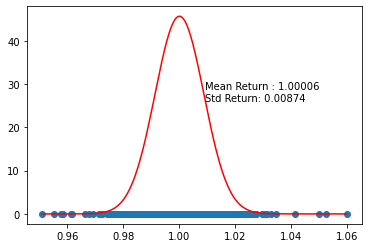

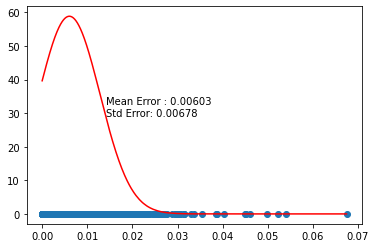

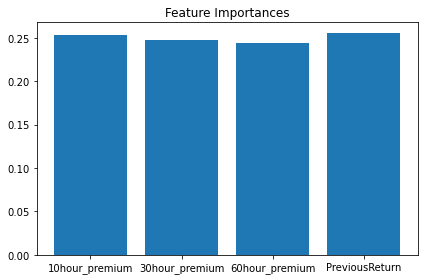

In [6]:
market_states, returns, trained_model, mean_err, std_err = train_model(training_dataset, 
                                                                       model, 
                                                                       visualise_performance=True)

## Trading Strategy Implementation

The strategy leveraging the trained modle is implemented in the ```TradingStrategy``` class and makes the following assumptions about the trading environment:
* The trading fee for executing a trade is constant
* The degree of price slippage is uniformly distributed over a given range
* The bet size for a given trade as a fraction of the current balance is fixed

Features and target values are passed to the ```market_history``` and ```historical_returns``` parameters respectively for the purposes of back testing.

In [7]:
class TradingStrategy:
    def __init__(self, 
                 model,
                 mean_err=None, 
                 std_err=None,
                 start_balance=1000., 
                 buy_threshold=1., 
                 bet_size=1., 
                 market_history=None,
                 historical_returns=None,
                 max_slippage=.005,
                 trading_fee=.005):
        
        self.predictor = {
            'model': model,
            'mean_error': mean_err,
            'std_error': std_err
        }
        self.buy_threshold = buy_threshold
        
        if isinstance(self.predictor['model'], TfKerasModel):
            self.predictor['model'].model.trainable = False
        
        self.balance = start_balance
        self.bet_size = bet_size
        self.current_bet = 0.
        
        self.backetest_results = {
            'balance':[start_balance],
            'prediction_error':[0.],
            'execution_history':[False]
        }
        
        assert len(market_history) == len(historical_returns), \
            'The number of market states must equal the number of subsequent returns'
        
        self.market_history = market_history
        self.historical_returns = historical_returns
        self.max_slippage = max_slippage
        self.trading_fee = trading_fee
        
    def execute_trade(self, state):
        trade_executed = False
        if len(state.shape) == 1:
            state = state[np.newaxis,:]
        predicted_return = self.predictor['model'].predict(state)[0]
        predicted_direction = predicted_return > self.buy_threshold
        if predicted_direction:
            expected_change = self.balance*self.bet_size
            self.balance -= expected_change
            self.current_bet += expected_change*(1 - self.max_slippage*np.random.random() - self.trading_fee)
            trade_executed = True
        return predicted_return, trade_executed

    def evaluate_trade(self, real_return):
        closing_position = self.current_bet*real_return
        self.balance += closing_position*(1 - self.max_slippage*np.random.random() - self.trading_fee)
        self.current_bet = 0

    def backtest(self, visualise_results=True):
        if self.market_history is not None:
            
            predictons = self.predictor['model'].predict(self.market_history)
            if len(predictons.shape) > 1:
                predictons = predictons.flatten()
            self.backetest_results['execution_history'] += list(predictons > self.buy_threshold)
            self.backetest_results['prediction_error'] += list(self.historical_returns - predictons)
            
            for idx in range(len(self.historical_returns)):
                old_balance = self.backetest_results['balance'][idx]
                if not self.backetest_results['execution_history'][idx+1]:
                    self.backetest_results['balance'].append(old_balance)
                else:
                    change = old_balance * (self.historical_returns.values[idx] - 1) * self.bet_size * \
                        (1 - self.max_slippage*np.random.random() - self.trading_fee)
                    self.backetest_results['balance'].append(old_balance + change)

            if visualise_results:
                plt.subplot(411)
                plt.title('Bitcoin Price in USD')
                plt.plot(self.market_history['prices'])
                plt.subplot(412)
                plt.title('Cash Balance')
                plt.plot(self.backetest_results['balance'], c='green')
                plt.subplot(413)
                plt.title('Actual Returns')
                plt.plot(self.historical_returns, c='orange')
                plt.subplot(414)
                plt.title('Prediction Error')
                plt.plot(self.backetest_results['prediction_error'], c='red')
                plt.tight_layout()
                plt.show()
        else:
            print('No historical data provided')
            exit()

## Backtesting the Strategy and Visualising Performance

The strategy is backtested against both the training data and data held out to get a sense for how well the approach generalises. For each time window, two sublots will be generated:
* The trade execution history (1 if a trade was executed, 0 if not)
* A comparison of the simulated trading balace using the machine learning based apprach compared to a 'buy and hold' strategy.

################################ From 2022-03-07 to 2022-06-05 ################################################################################################


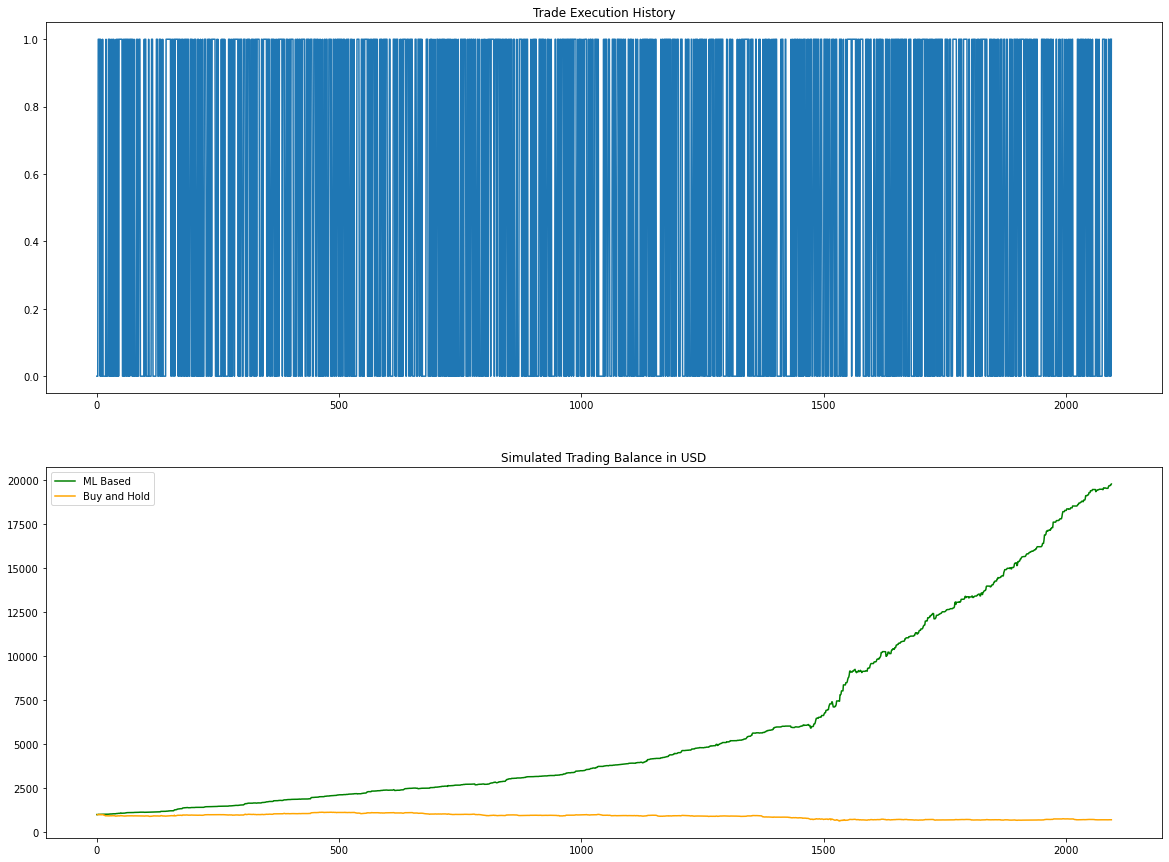

################################ From 2021-12-07 to 2022-03-07 ################################################################################################


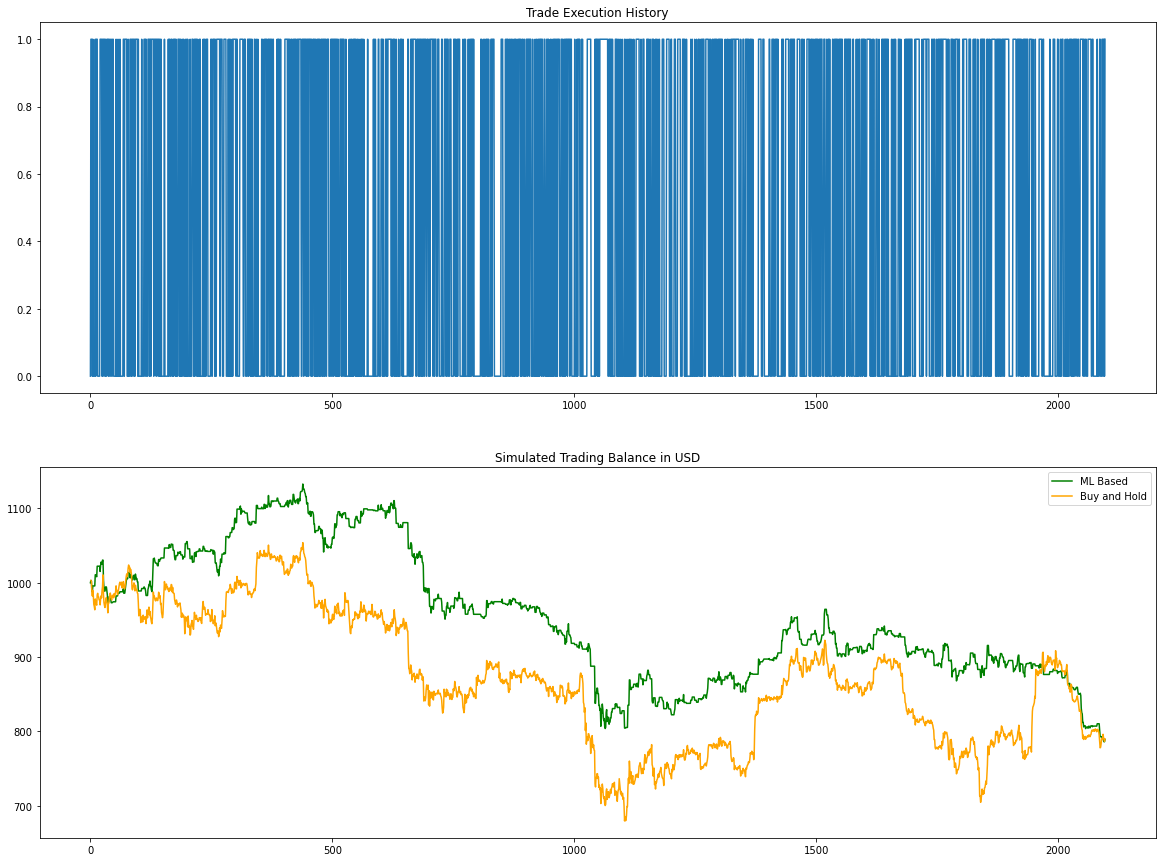

################################ From 2021-09-08 to 2021-12-07 ################################################################################################


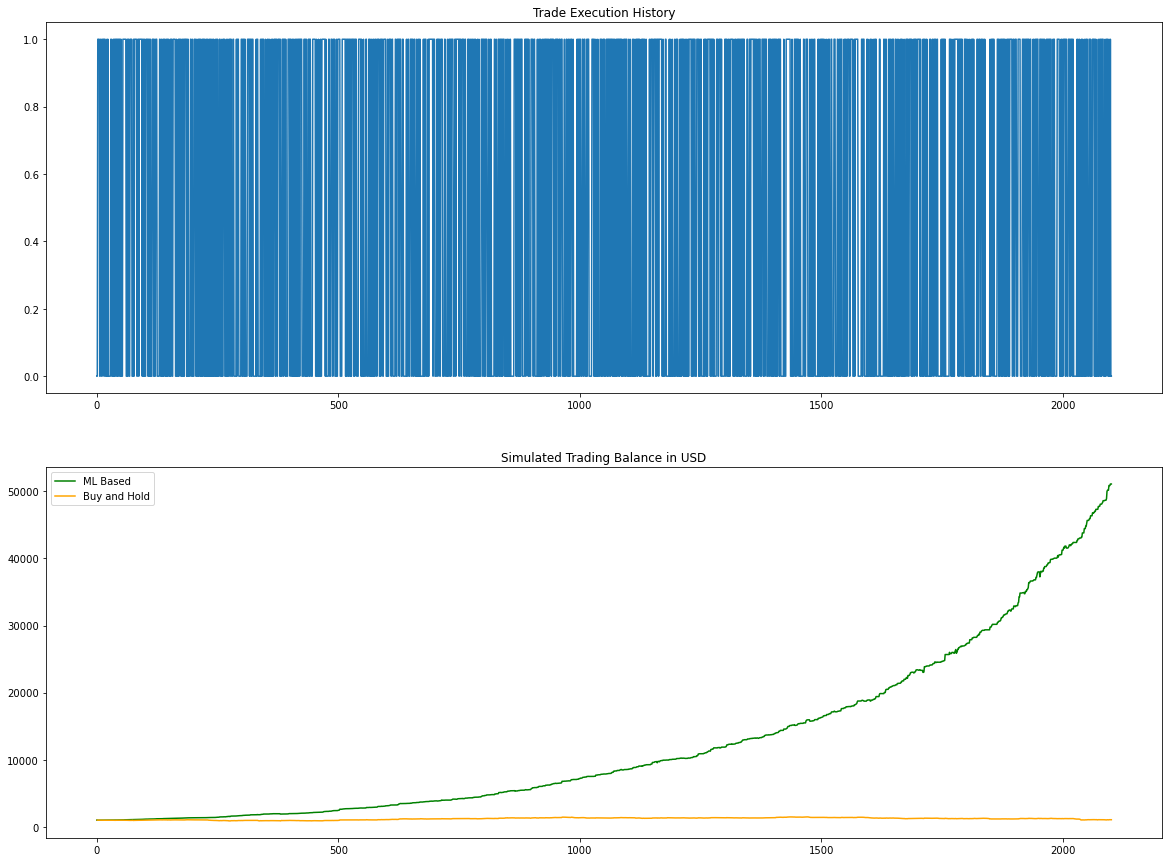

################################ From 2021-06-10 to 2021-09-08 ################################################################################################


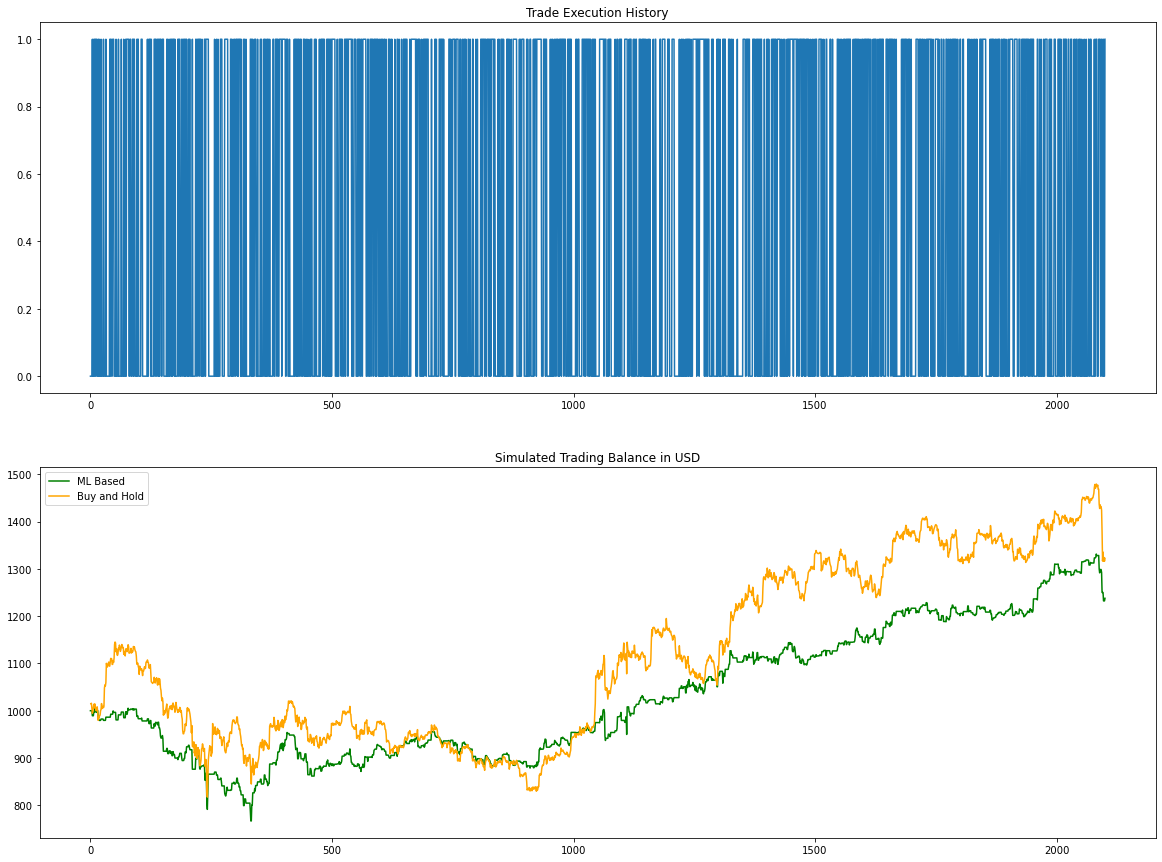

################################ From 2021-03-12 to 2021-06-10 ################################################################################################


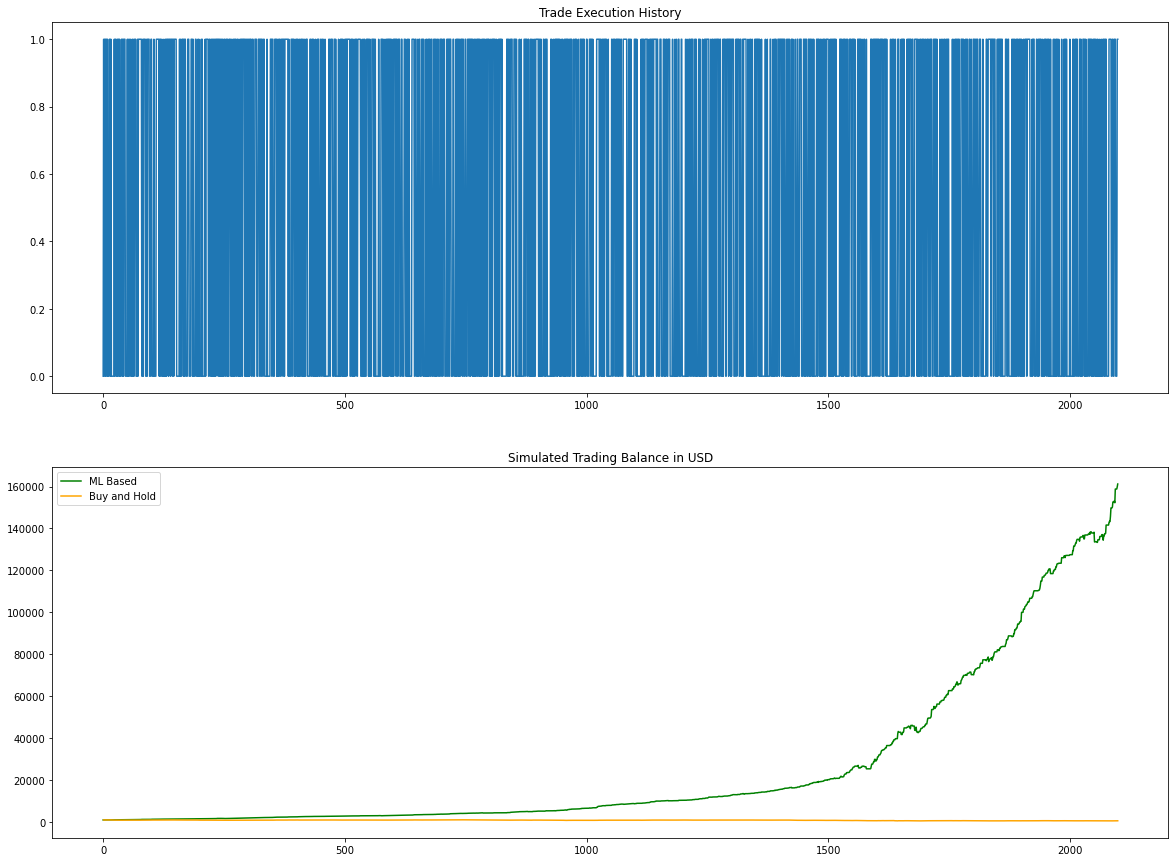

In [8]:
backtesting_data = [get_features_and_labels(d) for d in datasets]

for (x, y), date in zip(backtesting_data, start_dates):

    trading_strategy = TradingStrategy(trained_model,
                                       mean_err=mean_err,
                                       std_err=std_err,
                                       market_history=x,
                                       historical_returns=y)

    trading_strategy.backtest(visualise_results=False)

    start = date.isoformat()
    end = (date + timedelta(days=90)).isoformat()
    print(f'################################ From {start} to {end} ################################################################################################')
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    plt.title('Trade Execution History')
    plt.plot(trading_strategy.backetest_results['execution_history'])
    plt.subplot(212)
    plt.title('Simulated Trading Balance in USD')
    plt.plot(trading_strategy.backetest_results['balance'], c='green')
    plt.plot(y.cumprod()*trading_strategy.backetest_results['balance'][0], c='orange')
    plt.legend(['ML Based','Buy and Hold'])

    plt.show()

## Final Thoughts

Unsurpisingly, it has proven difficult to find an approach that both more profitable than 'buy and hold' and generalises beyond the training data. This is likely due to constantly eveolving market dynamics as well as event driven factors that cannot be appropriately capured in the data used in this experiment. An adaptive or mean reverting algorithmic approach may be a better avenue of exploration, however that will be set aside for future work.